In [1]:
import sys
sys.path.insert(0, "/kaggle/input/magnatagatune-pcm8-top50")
from magna_loader import MagnaLoader

In [2]:
mloader = MagnaLoader('/kaggle/input/magnatagatune-pcm8-top50/magnatagatune_pcm8_top50.bin')
mloader.samples_count

21108

In [3]:
import tensorflow as tf
import numpy as np
import gc

In [4]:
y_classes = 10
train_test_ratio = 0.9
test_x, test_y = [], []

from scipy import signal

def prepare_sample(x,y):
    #x = x.reshape((-1, 1)) / 128
    y = y[:y_classes].astype(np.float32)

    frequencies, times, spectrogram = signal.spectrogram(x*256, 16000)    
    spectrogram = (spectrogram.clip(0, 512)/512)
    spectrogram = spectrogram.reshape((*spectrogram.shape, 1))
    
    return spectrogram,y

x_usage = np.zeros(mloader.samples_count, dtype=np.int8)
for i, (x,y) in enumerate(mloader.iterate(prepare_sample)):
    if sum(y)==0: continue
    if i<train_test_ratio*mloader.samples_count:
        x_usage[i] = 1
    else:
        x_usage[i] = 2
        test_x.append(x)
        test_y.append(y)
        
test_x = np.array(test_x)
test_y = np.array(test_y)
gc.collect()

train_count = sum(x_usage==1)
print("Train count =", train_count)

def magna_generator():        
    while True:
        for i, (x,y) in enumerate(mloader.iterate(prepare_sample)):
            if x_usage[i]==1:
                yield x,y        

Train count = 14837


In [5]:
gc.collect()

0

In [6]:
test_x.shape, test_y.shape

((1635, 129, 2080, 1), (1635, 10))

In [7]:
x_shape = test_x.shape[1:]
y_shape = (y_classes,)

In [8]:
magna_dataset = tf.data.Dataset.from_generator(magna_generator, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=(x_shape, y_shape))
batch_size = 16
magna_dataset = magna_dataset.shuffle(150).batch(batch_size)

In [9]:
def create_cnnlstm_model():
    conv_cfg = {'kernel_size':(3,3), 'padding':'same', 'activation':'leaky_relu'}
    x = x0 = tf.keras.layers.Input(x_shape)
    x = tf.keras.layers.Conv2D(16, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(16, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(32, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(64, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(128, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling2D((2,1))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(128, **conv_cfg)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,1))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(128, **conv_cfg)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,1))(x)    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Reshape(x.shape[2:])(x)
   
    x = tf.keras.layers.GRU(256)(x)        
    x = tf.keras.layers.Dense(y_shape[-1], activation='sigmoid')(x)

    return tf.keras.models.Model(x0, x)

model = create_cnnlstm_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 129, 2080, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 129, 2080, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 1040, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 1040, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 1040, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 520, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 520, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 520, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 260, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 260, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 260, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 130, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 130, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 130, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 130, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 130, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 130, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 130, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 130, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2, 130, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 130, 128)         │         147,5

 Total params: 694,682 (2.65 MB)

 Trainable params: 694,170 (2.65 MB)

 Non-trainable params: 512 (2.00 KB)

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [11]:
history = model.fit(magna_dataset, 
                   epochs=10,
                   steps_per_epoch=train_count//batch_size,
                   validation_data=(test_x, test_y))

Epoch 1/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 241s 247ms/step - binary_accuracy: 0.8179 - loss: 0.4082 - val_binary_accuracy: 0.8457 - val_loss: 0.3265
Epoch 2/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 223s 241ms/step - binary_accuracy: 0.8410 - loss: 0.3468 - val_binary_accuracy: 0.8709 - val_loss: 0.2823
Epoch 3/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 223s 241ms/step - binary_accuracy: 0.8559 - loss: 0.3164 - val_binary_accuracy: 0.8538 - val_loss: 0.3007
Epoch 4/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 222s 240ms/step - binary_accuracy: 0.8614 - loss: 0.3058 - val_binary_accuracy: 0.8673 - val_loss: 0.2785
Epoch 5/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 221s 239ms/step - binary_accuracy: 0.8671 - loss: 0.2943 - val_binary_accuracy: 0.8683 - val_loss: 0.2707
Epoch 6/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 223s 240ms/step - binary_accuracy: 0.8704 - loss: 0.2862 - val_binary_accuracy: 0.8667 - val_loss: 0.3008
Epoch 7/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 222s 240ms/step - binary_accuracy: 0.8728 - loss: 0.2821 - val_binary_accuracy: 0.88

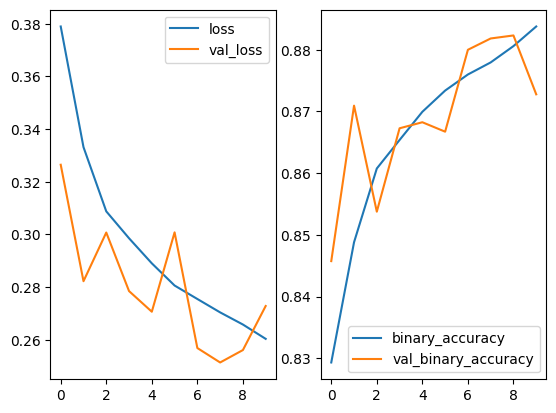

In [12]:
from matplotlib import pyplot as plt
fix, ax = plt.subplots(1,2)

ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['binary_accuracy'], label='binary_accuracy')
ax[1].plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
ax[1].legend()
plt.show()

In [13]:
del magna_dataset
gc.collect()

455

In [14]:
from sklearn.metrics import roc_curve
y_pred = model.predict(test_x)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


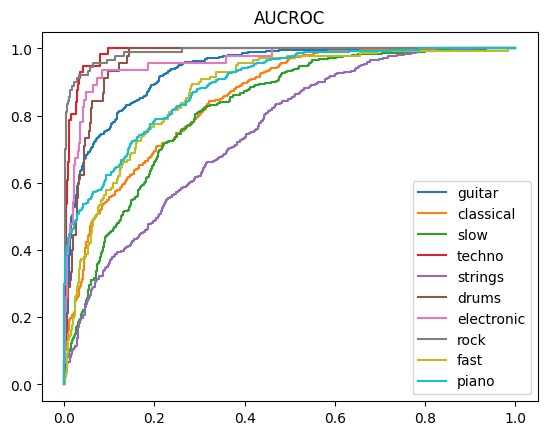

In [15]:
classes=["guitar", "classical", "slow", "techno", "strings", "drums", 
         "electronic", "rock", "fast", "piano"]
F = [None]*y_classes
T = [None]*y_classes
for i in range(y_classes):
    F[i], T[i], ths = roc_curve(test_y[:,i], y_pred[:,i], pos_label=1)
    plt.plot(F[i], T[i], label=classes[i])
plt.legend()
plt.title("AUCROC")
plt.show()

In [16]:
def auc(x,y):
    s = 0
    for i in range(1, len(x)):
        s += (y[i]+y[i-1])*abs((x[i]-x[i-1]))/2
    return s
for g, a in [(classes[i], auc(F[i], T[i])) for i in range(y_classes)]:
    print(g,a)

guitar 0.9344935155227985
classical 0.8504715896020243
slow 0.8203732067738109
techno 0.9874920835972134
strings 0.7501773952068
drums 0.9627393431167016
electronic 0.959641010206036
rock 0.9887522473930241
fast 0.8722677660066224
piano 0.8908273208273209


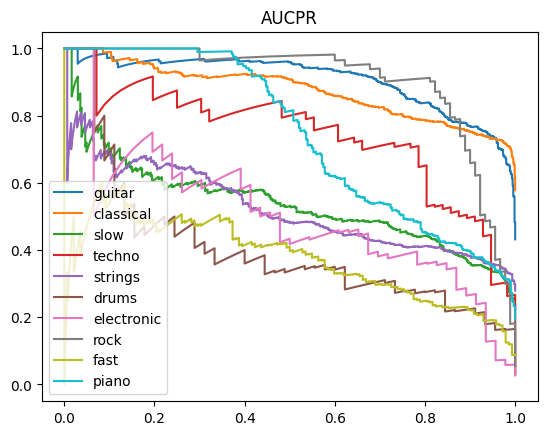

In [17]:
from sklearn.metrics import precision_recall_curve
P = [None]*y_classes
R = [None]*y_classes
for i in range(y_classes):
    P[i], R[i], ths = precision_recall_curve(test_y[:,i], y_pred[:,i], pos_label=1)
    plt.plot(R[i], P[i], label=classes[i])
plt.legend()
plt.title("AUCPR")
plt.show()

In [18]:
for g, a in [(classes[i], auc(R[i], P[i])) for i in range(y_classes)]:
    print(g,a)

guitar 0.9076546136060116
classical 0.8749760218199859
slow 0.5381684624524385
techno 0.7423148668562752
strings 0.5238067251294695
drums 0.4017605817973419
electronic 0.5013865558183576
rock 0.9042467344953815
fast 0.3729710819995416
piano 0.7413910981882691


In [19]:
from sklearn.metrics import confusion_matrix

for i in range(y_classes):
    print(classes[i])    
    cmat = confusion_matrix(test_y[:,i], y_pred[:,i]>=0.5)    
    print(cmat)
    p = cmat[0,0]/(cmat[0,0]+cmat[1,0])
    r = cmat[0,0]/(cmat[0,0]+cmat[0,1])
    print("Accuracy =", (cmat[0,0]+cmat[1,1])/(cmat[0,0]+cmat[0,1]+cmat[1,0]+cmat[1,1]))
    print("Prec =", p)
    print("Recall =", r)    
    print("F1 = ", 2*p*r/(p+r))

guitar
[[898  31]
 [278 428]]
Accuracy = 0.8110091743119267
Prec = 0.7636054421768708
Recall = 0.9666307857911733
F1 =  0.8532066508313539
classical
[[464 226]
 [149 796]]
Accuracy = 0.7706422018348624
Prec = 0.7569331158238173
Recall = 0.672463768115942
F1 =  0.7122026093630085
slow
[[1168  102]
 [ 229  136]]
Accuracy = 0.7975535168195719
Prec = 0.8360773085182533
Recall = 0.9196850393700787
F1 =  0.8758905136857892
techno
[[1550   29]
 [  11   45]]
Accuracy = 0.9755351681957186
Prec = 0.9929532351057014
Recall = 0.9816339455351488
F1 =  0.9872611464968152
strings
[[1082   96]
 [ 309  148]]
Accuracy = 0.7522935779816514
Prec = 0.7778576563623293
Recall = 0.9185059422750425
F1 =  0.8423511093810822
drums
[[1550   40]
 [  25   20]]
Accuracy = 0.9602446483180428
Prec = 0.9841269841269841
Recall = 0.9748427672955975
F1 =  0.9794628751974723
electronic
[[1554   35]
 [  17   29]]
Accuracy = 0.9681957186544342
Prec = 0.9891788669637174
Recall = 0.9779735682819384
F1 =  0.9835443037974684
roc